# Optiver Trading At The Close

[Competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close)

[GitHub Repository](https://github.com/cvaisnor/DNN-Final-Project)

[Google Slides Presentation](https://docs.google.com/presentation/d/1Xc5F1_NveFi1il3GqHej2aqVmklR_jZU4kx6ZJhiDEM/edit?usp=sharing)

# General Imports

In [ ]:
!pip show tensorflow

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential

In [2]:
import os
import numpy as np
import pandas as pd
import importlib

import helpers

kaggle_environment = False # True if running on Kaggle, don't forget to add the dataset!

from helpers.common import load_data, plot_predictions, submit_dummy_predictions
from helpers.pipeline import LogFeatures, LagFeatures, RollingMeanFeatures, DiffFeatures, ExpandingMeanFeatures, \
ForwardFillValues, FillZero, DataFrameWrapper, PolynomialFeaturesWrapper, MissingValueImputer, DropColumns, FillOne

if not kaggle_environment:
    # Reload the modules
    importlib.reload(helpers.common)
    importlib.reload(helpers.pipeline)

# Loading Data

In [3]:
original_train, test, revealed_targets, sample_submission = load_data(kaggle_environment)

In [4]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(original_train) * split_ratio)

train = original_train.iloc[:split_idx]
test = original_train.iloc[split_idx:]

train = train.dropna(subset=['target'])
test = test.dropna(subset=['target'])

# Subsample
max_samples = 100000
if train.shape[0] > max_samples:
    train = train[-max_samples:]

if test.shape[0] > max_samples:
    test = test[-max_samples:]
    
# train = train.dropna()
# test = test.dropna()

# y = train['target'].values
# y_test = test['target'].values

In [5]:
print(train.shape)
print(test.shape)

(100000, 17)
(100000, 17)


In [6]:
test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5137980,0,471,500,1467081.79,-1,0.997344,36059637.12,0.997002,0.997002,0.997344,40845.00,0.997515,41785.76,0.997428,1.230240,25955,471_500_0
5137981,1,471,500,479742.36,-1,0.998503,15727852.06,0.997559,0.997821,0.998188,67894.26,0.999186,70246.53,0.998679,-23.149849,25955,471_500_1
5137982,2,471,500,199076.21,1,1.000145,39893400.17,1.000291,1.000242,0.999900,354946.30,1.000340,27630.45,1.000308,2.269745,25955,471_500_2
5137983,3,471,500,7322026.95,-1,0.997682,92111805.96,0.997035,0.997284,0.997682,6011.40,0.997732,4007.80,0.997712,0.849962,25955,471_500_3
5137984,4,471,500,1811912.82,-1,0.999935,61508071.65,0.999705,0.999705,0.999935,173.76,1.000108,120957.84,0.999936,-0.680089,25955,471_500_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [7]:
# # Restructure training and test sets into RNN compatible training sequences
# # Assign Variables

# def generate_sequences(data, sequence_size, prediction_size, step_size, num_sequences):
#     past_sequences = []
#     future_prices = []
#     total_possible_sequences = (len(data) - prediction_size - sequence_size) // step_size
#     starting_sequence = total_possible_sequences - num_sequences

#     print (f'Data length: {len(data)}, starting_sequence: {starting_sequence}')

#     for i in range(starting_sequence, total_possible_sequences):
#         start_index = i * step_size
#         end_index = start_index + sequence_size
#         prediction_end_index = end_index + prediction_size

#         if prediction_end_index < len(data):
#           past_sequence = data.iloc[start_index:end_index, :].values
#           future_price_sequence = data.iloc[end_index:prediction_end_index, data.columns.get_loc('Close')].values

#           past_sequences.append(past_sequence)
#           future_prices.append(future_price_sequence)

#         else:
#             print(f'ERROR: Calculations were incorrect start index {start_index}, end index {end_index}, prediction end index {prediction_end_index}')

#     return np.array(past_sequences), np.array(future_prices)

# num_train_samples = train.shape[0]
# num_test_samples = train.shape[0]
# num_training_sequences = 3500
# num_test_sequences = 200
# prediction_size = 1
# step_size = 1

# print('Creating training data')
# train_inputs, train_outputs = generate_sequences(
#     train,
#     num_train_samples,
#     prediction_size,
#     step_size,
#     num_training_sequences
# )

# print('Creating test data')
# test_inputs, test_outputs = generate_sequences(
#     test,
#     num_test_samples,
#     prediction_size,
#     step_size,
#     num_test_sequences
# )


# Feature Engineering Section

In [8]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# drop_columns=['target', 'bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']
# drop_columns=['target', 'bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']
drop_columns=['bid_size', 'ask_size', 'imbalance_size', 'matched_size', 'time_id', 'row_id', 'currently_scored']

# Main Pipeline
pipeline = Pipeline([
    ('logs', LogFeatures(['imbalance_size', 'matched_size', 'bid_size', 'ask_size'])),
    ('wap_lags', LagFeatures(['wap'], [1, 6], 1.0)),
    ('matched_size_lags', LagFeatures(['matched_size'], [1, 6], 0.0)),
    ('wap_rolling_means', RollingMeanFeatures(['wap'], [2])),
    ('diff_features', DiffFeatures(['wap', 'imbalance_buy_sell_flag', 'matched_size_log', 'ask_price', 'reference_price'])),
    ('diff_features_2', DiffFeatures(['wap_diff', 'matched_size_log_diff', 'ask_price_diff', 'reference_price_diff'])),
    ('diff_features_3', DiffFeatures(['wap_diff_diff', 'matched_size_log_diff_diff', 'ask_price_diff_diff', 'reference_price_diff_diff'])),
    ('wap_expanding_mean', ExpandingMeanFeatures(['wap'])),
    ('drop_columns', DropColumns(drop_columns)),
#     ('missing_value_imputer', MissingValueImputer(['far_price', 'near_price'])),
    ('forward_fill', ForwardFillValues()),
    # ('fill_zero', FillZero()),
    ('fill_one', FillOne()),
    # ('preprocessor', DataFrameWrapper(preprocessor, columns_to_keep)),
    # ('drop_grouping_columns', DropColumns(['stock_id', 'date_id'])),
    ('scaler', DataFrameWrapper(StandardScaler())),
    # ('poly', PolynomialFeaturesWrapper(2)),
])

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    train_preprocessed = pipeline.fit_transform(train)
    test_preprocessed = pipeline.transform(test)

CPU times: user 1.26 s, sys: 137 ms, total: 1.4 s
Wall time: 1.4 s


In [9]:
# X = train_transformed
# X_test = test_transformed

In [10]:
train_preprocessed.dtypes

stock_id                           float64
date_id                            float64
seconds_in_bucket                  float64
imbalance_buy_sell_flag            float64
reference_price                    float64
far_price                          float64
near_price                         float64
bid_price                          float64
ask_price                          float64
wap                                float64
target                             float64
imbalance_size_log                 float64
matched_size_log                   float64
bid_size_log                       float64
ask_size_log                       float64
wap_lag_1                          float64
wap_lag_6                          float64
matched_size_lag_1                 float64
matched_size_lag_6                 float64
wap_rolling_mean2                  float64
wap_diff                           float64
imbalance_buy_sell_flag_diff       float64
matched_size_log_diff              float64
ask_price_d

In [11]:
# X['wap_lag_1']
# X[seconds_in_bucket]

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def create_predict_sequences(df, feature_columns, max_sequence_length=60):
    """
    Create sequences for RNN predictions.

    :param df: Pandas DataFrame containing the data.
    :param feature_columns: List of column names to be used as features.
    :param max_sequence_length: Maximum length of sequences.
    :return: Tuple (X, y) of sequences and their corresponding targets.
    """
    X = []

    for _, group in df.groupby(['stock_id', 'date_id']):
        sequences = group[feature_columns].values
        padded_sequences = pad_sequences([sequences], maxlen=max_sequence_length, padding='pre', dtype='float32')[0]

        X.append(padded_sequences)

    return np.array(X)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def create_sequences(df, feature_columns, max_sequence_length=60, step_size=3):
    """
    Create sequences for RNN training, aiming to predict all values for each day.

    :param df: Pandas DataFrame containing the data.
    :param feature_columns: List of column names to be used as features.
    :param max_sequence_length: Maximum length of sequences.
    :return: Tuple (X, y) of sequences and their corresponding targets.
    """
    X = []  # Features
    y = []  # Targets

    # Group by 'stock_id' and 'date_id'
    for _, group in df.groupby(['stock_id', 'date_id']):
        # Extract features and targets
        group_features = group[feature_columns].values
        group_targets = group['target'].values

        # Generate multiple sequences for each group
        for i in range(0, len(group), step_size):
            # Define the end of the sequence
            end_idx = i + 5

            # If there are not enough previous timesteps for a full sequence,
            # pad the sequence at the beginning
            if end_idx < max_sequence_length:
                sequence = group_features[:end_idx]
                sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding='pre', dtype='float32')[0]
            else:
                start_idx = end_idx - max_sequence_length
                sequence = group_features[start_idx:end_idx]

            X.append(sequence)
            y.append(group_targets[i])

    return np.array(X), np.array(y)

feature_columns = train_preprocessed.columns.difference(['stock_id', 'date_id', 'target'])
X_train, y_train = create_sequences(train_preprocessed, feature_columns)
X_test, y_test = create_sequences(test_preprocessed, feature_columns)


In [16]:
print(f'Sequences: {len(X_train)}, Samples per sequence: {len(X_train[0])}, number of features per sample {len(X_train[0][0])}')

Sequences: 34404, Samples per sequence: 60, number of features per sample 31


All feature transformations should be combined into a generate_feature() function. This can then be applied to the test data will in the for loop for the Optiver API.

In [17]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)

    predict_sequences, _ = create_predict_sequences(transformed_df, feature_columns)

    return predict_sequences    
    # Only return rows corresponding to the current test dataframe
    # return transformed_df.iloc[-len(current_test):]


# Slicing

Generally, don't change the cell below. It is used to slice the data into training and validation sets.

In [18]:
# imports
# from sklearn.model_selection import train_test_split

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X
# y_train = y 

# Model Development

In [19]:
%%time
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential

tf.random.set_seed(0)
Init = tf.keras.initializers.GlorotUniform(seed=0)

num_features = 31
num_predictions = 1
gru_size = 200


# Example: Reshape X_train to have 10 timesteps

# num_timesteps = 600
# subset_size = 20000

# X_train_subset = X_train.iloc[-subset_size:]

# # Adjust num_samples based on the subset size
# num_samples = X_train_subset.shape[0] - num_timesteps + 1

# # Initialize the reshaped training data array
# X_train_reshaped = np.zeros((num_samples, num_timesteps, num_features))
# y_train_subset = y_train[-X_train_reshaped.shape[0]:]


# # Populate the reshaped array
# for i in range(num_samples):
#     X_train_reshaped[i] = X_train_subset.values[i:i+num_timesteps]

# Now use the reshaped array for training
# hist = rnn.fit(X_train_reshaped, y_train, epochs=5, batch_size=16, callbacks=callbacks)


rnn = Sequential(
    [
        GRU(gru_size, return_sequences=True, input_shape=[None, num_features], name='GRU1', kernel_initializer=Init, recurrent_initializer=Init),
        Dropout(.2, name='d1'),
        GRU(gru_size, name='GRU2', kernel_initializer=Init, recurrent_initializer=Init),
        Dropout(.2, name='d2'),
        Dense(num_predictions, name='out', kernel_initializer=Init)
    ],
    name='RNN_model'
)

rnn.compile(optimizer='adam', loss='mean_absolute_error')
callbacks = []
hist = rnn.fit(X_train, y_train, epochs=1, batch_size=32, callbacks=callbacks)

1076/1076 [==============================] - 149s 137ms/step - loss: 0.6017
CPU times: user 2min 42s, sys: 1min 34s, total: 4min 16s
Wall time: 2min 28s


In [20]:
# %%time
# import lightgbm as lgb


# # lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, force_col_wise=True,
# #                          verbose=-1, boosting_type='gbdt', num_leaves=10,
# #                          reg_alpha=0, reg_lambda=0.2, objective='regression_l1')

# # lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, objective='regression_l1', num_leaves=100)
# lgbm = lgb.LGBMRegressor(n_jobs=-1, reg_lambda=0.2, random_state=0, num_leaves=650, boosting_type='gbdt', reg_alpha=0.2, objective='regression_l1')
# lgbm.fit(X_train, y_train)
# # lgbm.fit(X_train.drop(columns=['row_id', 'time_id', 'target']), y_train)


In [21]:
model = rnn

In [22]:
# lgbm.score(X_test, y_test)

from sklearn.metrics import mean_absolute_error

# predictions = model.predict(X_test.drop(columns=['row_id', 'time_id', 'target']))

# X_test_subset = X_test.iloc[-subset_size:]

# # Adjust num_samples based on the subset size
# num_samples = X_test_subset.shape[0] - num_timesteps + 1

# # Initialize the reshaped testing data array
# X_test_reshaped = np.zeros((num_samples, num_timesteps, num_features))
# y_test_subset = y_test[-X_test_reshaped.shape[0]:]


# # Populate the reshaped array
# for i in range(num_samples):
#     X_test_reshaped[i] = X_test_subset.values[i:i+num_timesteps]


predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on the test set: {mae:.4f}")
# predictions2 = model.predict(X_train.drop(columns=['row_id', 'time_id', 'target']))
predictions2 = model.predict(X_train)
mae2 = mean_absolute_error(y_train, predictions2)
print(f"Mean Absolute Error on the training set: {mae2:.4f}")

1082/1082 [==============================] - 51s 47ms/step
Mean Absolute Error on the test set: 0.4668
1076/1076 [==============================] - 49s 46ms/step
Mean Absolute Error on the training set: 0.5636


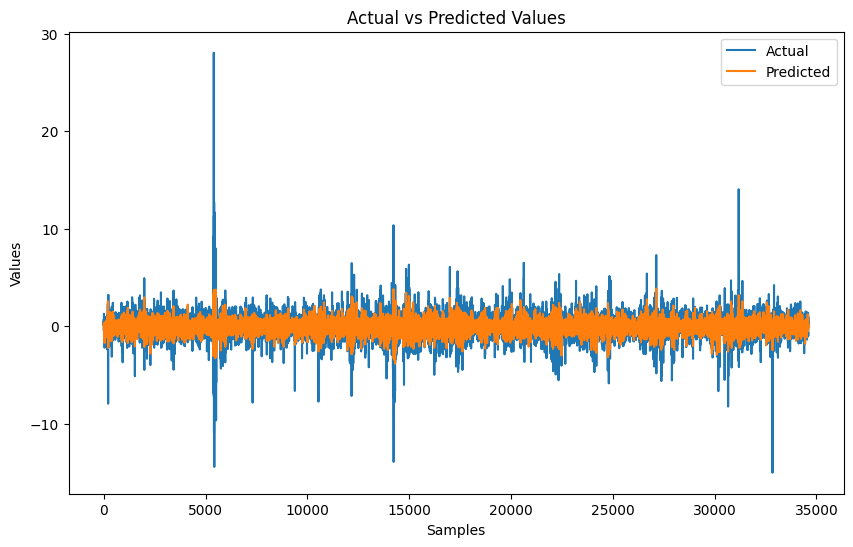

In [23]:
plot_predictions(y_test, predictions)

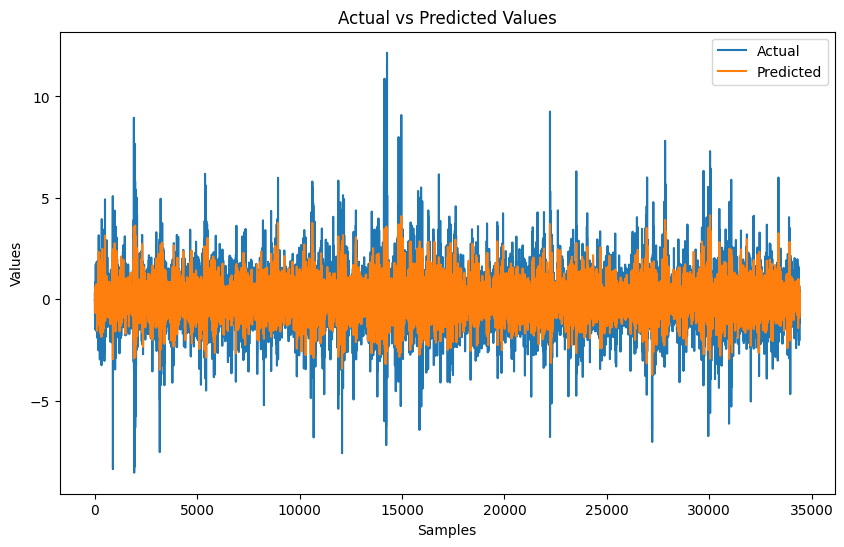

In [24]:
plot_predictions(y_train, predictions2)

In [25]:
print(predictions.min(), predictions.max())

-3.841069 3.864067


In [ ]:
# convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values

In [ ]:
# # Uncomment to use NN as the model instead
# # convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values
# # creating the model and fitting it on the data from the original sklearn train test split
# model = PyTorchMLP(input_size=X_train.shape[1], hidden_size=128)
# model.fit(X_train, y_train, X_test, y_test, epochs=2, batch_size=256, learning_rate=0.001, device=device)

# Generating Predictions

Only for Kaggle:
When uploading notebook, make sure to add the Optiver data on the right side of the screen.

In [ ]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [ ]:
# Uncomment this cell to try to get unstuck from having to restart and run the whole notebook again
# submit_dummy_predictions(env, sample_prediction)

In [ ]:
# if kaggle_environment:
#     # To count how many time the "for loop" runs.
#     counter = 0

#     # init 3 empty lists
#     # test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
#     cumulative_test_df = pd.DataFrame()

#     for (test_in, revealed_targets, sample_prediction) in iter_test:
#         # Append the dataframe that API return into the list.
#         # test_ls.append(test_in.copy())
#         # revealed_targets_ls.append(revealed_targets.copy())
#         # sample_prediction_ls.append(sample_prediction.copy())

#         current_date_id = test_in.iloc[0]['date_id']
#         current_date_rows = cumulative_test_df[cumulative_test_df['current_date_id'] == date_id_to_keep]
#         cumulative_test_df = pd.concat([current_date_rows, test_in], axis=0, ignore_index=True)

#         # Generate features
#         test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

#         # Writes our predictions 
#         sample_prediction["target"] = model.predict(test_transformed)
        
#         # This line submit our predictions.
#         env.predict(sample_prediction)
#         counter += 1

#     print('\n', '=' * 50, sep="")
#     print(f"counter: {counter}")

In [ ]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    # test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        # test_ls.append(test_in.copy())
        # revealed_targets_ls.append(revealed_targets.copy())
        # sample_prediction_ls.append(sample_prediction.copy())

        test_in['target'] = 0
        current_date_id = test_in.iloc[0]['date_id']
        cumulative_test_df = pd.concat([cumulative_test_df, test_in], axis=0, ignore_index=True)
#         if len(cumulative_test_df.columns) > 0:
        cumulative_test_df = cumulative_test_df[cumulative_test_df['date_id'] == current_date_id]
#             cumulative_test_df = pd.concat([current_date_rows, test_in], axis=0, ignore_index=True)
        print(f'{counter}: {cumulative_test_df.shape[0]}')

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

        # Writes our predictions 
        sample_prediction["target"] = model.predict(test_transformed)
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

In [ ]:
# cumulative_test_df.to_csv('file.csv')

In [ ]:
y_test.var()